In [32]:
# Modellvergleich: Baseline vs. Finetuned CryptoBERT und FinBERT

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [33]:
# 1. Testdaten laden
comments_df = pd.read_csv("../../data/processed/test_data_comments.csv")
X_comments = comments_df["text"].tolist()
y_comments = comments_df["label"].tolist()

posts_df = pd.read_csv("../../data/processed/test_data_posts.csv")
X_posts = posts_df["text"].tolist()
y_posts = posts_df["label"].tolist()

In [34]:
# 2. Baseline CryptoBERT laden
cryptobert_base = AutoModelForSequenceClassification.from_pretrained("ElKulako/cryptobert")
cryptobert_tokenizer = AutoTokenizer.from_pretrained("ElKulako/cryptobert")
cryptobert_pipeline = pipeline("text-classification", model=cryptobert_base, tokenizer=cryptobert_tokenizer, return_all_scores=False)

# 3. Finetuned CryptoBERT laden
cryptobert_finetuned_path = "../../models/experiments/cryptobert_comments/finetuned_lr_1e-05/checkpoint-1500/"
cryptobert_finetuned = AutoModelForSequenceClassification.from_pretrained(cryptobert_finetuned_path)
cryptobert_finetuned_tokenizer = AutoTokenizer.from_pretrained(cryptobert_finetuned_path)
cryptobert_finetuned_pipeline = pipeline("text-classification", model=cryptobert_finetuned, tokenizer=cryptobert_finetuned_tokenizer, return_all_scores=False)

# 4. Baseline FinBERT laden
finbert_base = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_base_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert_base_pipeline = pipeline("text-classification", model=finbert_base, tokenizer=finbert_base_tokenizer, return_all_scores=False)

# 5. Finetuned FinBERT laden
finbert_finetuned_path = "../../models/experiments/finbert_posts/finetuned_lr_2e-05/checkpoint-640/"
finbert_finetuned = AutoModelForSequenceClassification.from_pretrained(finbert_finetuned_path)
finbert_finetuned_tokenizer = AutoTokenizer.from_pretrained(finbert_finetuned_path)
finbert_finetuned_pipeline = pipeline("text-classification", model=finbert_finetuned, tokenizer=finbert_finetuned_tokenizer, return_all_scores=False)

Device set to use cuda:0
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [39]:
def predict(texts, tokenizer, model):
    model.to("cuda" if torch.cuda.is_available() else "cpu").eval()
    return [
        int(torch.argmax(model(**tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)).logits))
        for text in texts
    ]


In [40]:
cryptobert_base_preds = predict(X_comments, cryptobert_tokenizer, cryptobert_base)
cryptobert_finetuned_preds = predict(X_comments, cryptobert_finetuned_tokenizer, cryptobert_finetuned)

finbert_base_preds = predict(X_posts, finbert_base_tokenizer, finbert_base)
finbert_finetuned_preds = predict(X_posts, finbert_finetuned_tokenizer, finbert_finetuned)


In [42]:
# 7. Evaluation
print("\nCryptoBERT Base (Comments):")
print(classification_report(y_comments, encryptobert_base_preds))

print("\nCryptoBERT Finetuned (Comments):")
print(classification_report(y_comments, cryptobert_finetuned_preds))

print("\nFinBERT Base (Posts):")
print(classification_report(y_posts, finbert_base_preds))

print("\nFinBERT Finetuned (Posts):")
print(classification_report(y_posts, finbert_finetuned_preds))


CryptoBERT Base (Comments):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       333
           1       0.73      0.55      0.63       333
           2       0.02      0.03      0.03       333

    accuracy                           0.19       999
   macro avg       0.25      0.19      0.22       999
weighted avg       0.25      0.19      0.22       999


CryptoBERT Finetuned (Comments):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       333
           1       0.96      0.87      0.91       333
           2       0.94      0.95      0.95       333

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999


FinBERT Base (Posts):
              precision    recall  f1-score   support

           0       0.32      0.89      0.48       122
           1       0.75      0.13      0.21

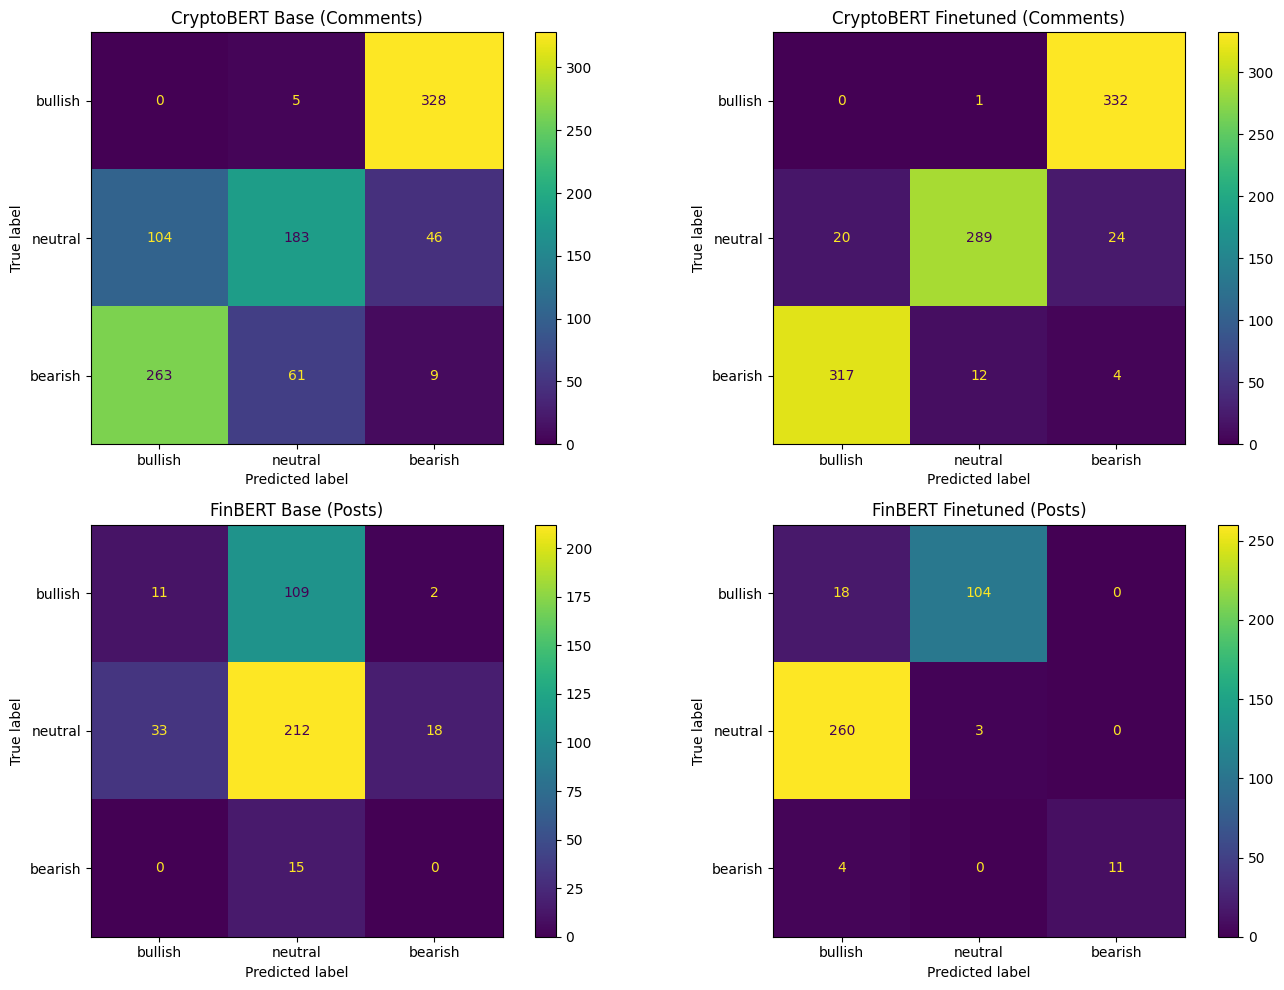

In [38]:
# 8. Visualisierung
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
ConfusionMatrixDisplay.from_predictions(y_comments, encryptobert_base_preds, ax=ax[0, 0], display_labels=["bullish", "neutral", "bearish"])
ax[0, 0].set_title("CryptoBERT Base (Comments)")

ConfusionMatrixDisplay.from_predictions(y_comments, cryptobert_finetuned_preds, ax=ax[0, 1], display_labels=["bullish", "neutral", "bearish"])
ax[0, 1].set_title("CryptoBERT Finetuned (Comments)")

ConfusionMatrixDisplay.from_predictions(y_posts, finbert_base_preds, ax=ax[1, 0], display_labels=["bullish", "neutral", "bearish"])
ax[1, 0].set_title("FinBERT Base (Posts)")

ConfusionMatrixDisplay.from_predictions(y_posts, finbert_finetuned_preds, ax=ax[1, 1], display_labels=["bullish", "neutral", "bearish"])
ax[1, 1].set_title("FinBERT Finetuned (Posts)")

plt.tight_layout()
plt.show()